In [1]:
path="/content/dataset.csv"
test="/content/test.csv"
sample="/content/sample_submission.csv"

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [3]:
df=pd.read_csv(path)
df.head()

,id,sale_date,sale_price,sale_nbr,sale_warning,join_status,join_year,latitude,longitude,area,...,view_olympics,view_cascades,view_territorial,view_skyline,view_sound,view_lakewash,view_lakesamm,view_otherwater,view_other,submarket
0,0,2014-11-15,236000,2.0,,nochg,2025,47.2917,-122.3658,53,...,0,0,0,0,0,0,0,0,0,I
1,1,1999-01-15,313300,NaN,26,nochg,2025,47.6531,-122.1996,74,...,0,0,0,0,0,1,0,0,0,Q
2,2,2006-08-15,341000,1.0,,nochg,2025,47.4733,-122.1901,30,...,0,0,0,0,0,0,0,0,0,K
3,3,1999-12-15,267000,1.0,,nochg,2025,47.4739,-122.3295,96,...,0,0,0,0,0,0,0,0,0,G
4,4,2018-07-15,1650000,2.0,,miss99,2025,47.7516,-122.1222,36,...,0,0,0,0,0,0,0,0,0,P


## Working with data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 47 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                200000 non-null  int64  
 1   sale_date         200000 non-null  object 
 2   sale_price        200000 non-null  int64  
 3   sale_nbr          157818 non-null  float64
 4   sale_warning      200000 non-null  object 
 5   join_status       200000 non-null  object 
 6   join_year         200000 non-null  int64  
 7   latitude          200000 non-null  float64
 8   longitude         200000 non-null  float64
 9   area              200000 non-null  int64  
 10  city              200000 non-null  object 
 11  zoning            200000 non-null  object 
 12  subdivision       182450 non-null  object 
 13  present_use       200000 non-null  int64  
 14  land_val          200000 non-null  int64  
 15  imp_val           200000 non-null  int64  
 16  year_built        20

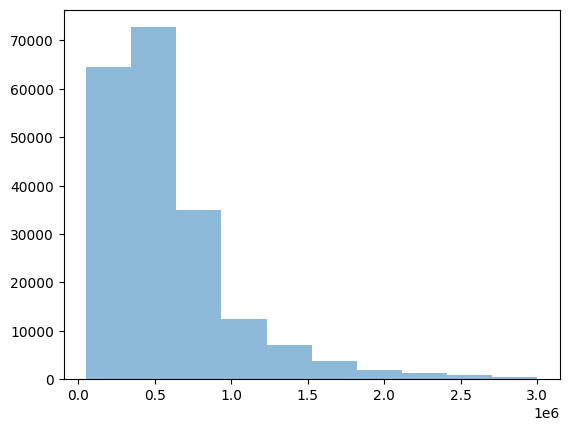

In [8]:
plt.hist(df['sale_price'],alpha=0.5)
plt.show()

## EDA

In [9]:
# Drop attributes which do not have any affect on prediction
def drop_attributes(df):
  return df.drop(['id','sale_nbr','sale_warning','join_status','join_year','subdivision'],axis=1)
df=drop_attributes(df)

In [10]:
# There are some null values, lets work on them
df.isna().sum()

,0
sale_date,0
sale_price,0
latitude,0
longitude,0
area,0
city,0
zoning,0
present_use,0
land_val,0
imp_val,0


In [11]:
df['submarket'].unique()

array(['I', 'Q', 'K', 'G', 'P', 'B', 'D', 'O', 'L', 'R', 'J', 'N', 'E',
       'M', 'A', 'F', nan, 'H', 'C', 'S'], dtype=object)

In [12]:
df['submarket']=df['submarket'].fillna(df['submarket'].mode()[0])
df['submarket'].unique()

array(['I', 'Q', 'K', 'G', 'P', 'B', 'D', 'O', 'L', 'R', 'J', 'N', 'E',
       'M', 'A', 'F', 'H', 'C', 'S'], dtype=object)

In [13]:
column=['sale_date','city','zoning','submarket']
oe=OrdinalEncoder()
def ordinal_encode(df,column):
  df[column]=oe.fit_transform(df[column])
ordinal_encode(df,column)

In [14]:
df['total_val']=df['land_val']+df['imp_val']
df=df.drop(['land_val','imp_val'],axis=1)

,sale_date,sale_price,latitude,longitude,area,city,zoning,present_use,land_val,imp_val,...,view_olympics,view_cascades,view_territorial,view_skyline,view_sound,view_lakewash,view_lakesamm,view_otherwater,view_other,submarket
0,190.0,236000,47.2917,-122.3658,53,13.0,417.0,2,167000,372000,...,0,0,0,0,0,0,0,0,0,8.0
1,0.0,313300,47.6531,-122.1996,74,19.0,402.0,2,1184000,598000,...,0,0,0,0,0,1,0,0,0,16.0
2,91.0,341000,47.4733,-122.1901,30,30.0,283.0,2,230000,356000,...,0,0,0,0,0,0,0,0,0,10.0
3,11.0,267000,47.4739,-122.3295,96,6.0,407.0,2,190000,518000,...,0,0,0,0,0,0,0,0,0,6.0
4,234.0,1650000,47.7516,-122.1222,36,18.0,348.0,2,616000,1917000,...,0,0,0,0,0,0,0,0,0,15.0


In [17]:
ss=StandardScaler()
df['total_val']=ss.fit_transform(df[['total_val']])

In [18]:
df.head()

,sale_date,sale_price,latitude,longitude,area,city,zoning,present_use,year_built,year_reno,...,view_cascades,view_territorial,view_skyline,view_sound,view_lakewash,view_lakesamm,view_otherwater,view_other,submarket,total_val
0,190.0,236000,47.2917,-122.3658,53,13.0,417.0,2,1975,0,...,0,0,0,0,0,0,0,0,8.0,-0.690873
1,0.0,313300,47.6531,-122.1996,74,19.0,402.0,2,1962,0,...,0,0,0,0,1,0,0,0,16.0,1.388737
2,91.0,341000,47.4733,-122.1901,30,30.0,283.0,2,1986,0,...,0,0,0,0,0,0,0,0,10.0,-0.612240
3,11.0,267000,47.4739,-122.3295,96,6.0,407.0,2,1998,0,...,0,0,0,0,0,0,0,0,6.0,-0.408127
4,234.0,1650000,47.7516,-122.1222,36,18.0,348.0,2,1998,0,...,0,0,0,0,0,0,0,0,15.0,2.645203


## Model Training

In [29]:
X=df.drop('sale_price',axis=1)
y=df['sale_price']

In [30]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [70]:
# train_data = lgb.Dataset(x_train, label=y_train)
# # Train Mean Model
# params_mean = {
#     "objective": "regression",
#     "metric": "mae",
#     "verbosity": -1
# }
# model_mean = lgb.train(params_mean, train_data)

train_data = lgb.Dataset(x_train, label=y_train)
params = {
    "objective": "quantile",
    "alpha": 0.1,
    "verbosity": -1
}
lgb_lower= lgb.train(params, train_data)

params["alpha"] = 0.9
lgb_upper = lgb.train(params, train_data)

In [32]:
y_pred=model_mean.predict(x_test)
mean_absolute_error(y_test,y_pred)

70022.15534153354

## Test dataset

In [76]:
df_test=pd.read_csv(test)
df_test.head()

,id,sale_date,sale_nbr,sale_warning,join_status,join_year,latitude,longitude,area,city,...,view_olympics,view_cascades,view_territorial,view_skyline,view_sound,view_lakewash,view_lakesamm,view_otherwater,view_other,submarket
0,200000,2022-12-15,4.0,,new,2025,47.4794,-122.2212,25,RENTON,...,0,0,0,0,0,0,0,0,0,J
1,200001,2000-10-15,2.0,,new,2025,47.5778,-122.0270,69,SAMMAMISH,...,0,0,0,0,0,0,0,0,0,O
2,200002,2004-06-15,1.0,,nochg,2025,47.5632,-122.1623,31,BELLEVUE,...,3,0,3,3,0,2,0,0,0,R
3,200003,2009-11-15,1.0,,nochg,2025,47.6911,-122.3469,6,SEATTLE,...,0,0,0,0,0,0,0,0,0,B
4,200004,1999-06-15,1.0,,reno - before,1999,47.4001,-122.4146,100,KING COUNTY,...,0,2,4,0,3,0,0,0,0,H


In [63]:
df_test=drop_attributes(df_test)

In [64]:
df_test.isna().sum()

,0
sale_date,0
latitude,0
longitude,0
area,0
city,0
zoning,0
present_use,0
land_val,0
imp_val,0
year_built,0


In [65]:
df_test['submarket']=df_test['submarket'].fillna(df_test['submarket'].mode()[0])

In [66]:
ordinal_encode(df_test,column)

In [72]:
df_test['total_val']=df_test['land_val']+df_test['imp_val']
df_test=df_test.drop(['land_val','imp_val'],axis=1)

In [73]:
pi_lower=lgb_lower.predict(df_test)

In [74]:
pi_higher=lgb_upper.predict(df_test)

In [78]:
submission = pd.DataFrame({"id":df_test['id'],"pi_lower": pi_lower, "pi_upper": pi_higher})
submission.to_csv("submission.csv", index=False)